## MLDC Mapping

1. **Problem Definition** → Emotion detection from EEG
2. **Data Collection** → Load EEG CSV from `dataset/emotions.csv`
3. **Data Processing** → Missing values + scaling
4. **EDA** → Shape, samples, statistics
5. **Feature Engineering** → Raw feature columns (baseline)
6. **Model Selection** → Linear + Logistic Regression
7. **Deployment** → Exported to web UI in this project


### Dataset Used (Kaggle emotions.csv)
- File: `dataset/emotions.csv` (EEG Brainwave Dataset: Feeling Emotions)
- 2548 feature columns + 1 label column
- Labels: **positive / neutral / negative** (last column)


## 1) Problem Definition
We want to predict emotion dimensions from EEG: **valence**, **arousal**, **dominance**.


## 2) Imports


In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
np.seterr(all='ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

from pathlib import Path
import matplotlib.pyplot as plt

## 3) Data Loading
Load the EEG data file with channel columns.


In [2]:
data_path = Path("../dataset/emotions.csv")
if not data_path.exists():
    raise FileNotFoundError("Please download Kaggle emotions.csv and place it at dataset/emotions.csv")

data = pd.read_csv(data_path)
# Drop any unnamed index column
if data.columns.str.contains('^Unnamed').any():
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


## 4) EDA (Basic Exploration)


In [3]:
data.shape


(2132, 2549)

In [4]:
data.describe().loc[["mean", "std"]].head()


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
mean,15.256914,27.012462,-104.975629,13.605898,24.150483,0.025378,0.052282,0.301655,0.036793,0.083567,...,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,15.284621,9.265141,206.271960,16.874676,14.187340,17.981796,8.509174,68.098894,17.010031,18.935378,...,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976


## 5) Preprocessing
- Fill missing values
- Scale features for ML


In [5]:
# Identify label column (use known names or fallback to last column)
label_col = None
for c in data.columns:
    if c.lower() in ['label','emotion','emotions','state','category']:
        label_col = c
        break
if label_col is None:
    label_col = data.columns[-1]

# Separate labels and features
y_raw = data[label_col].astype(str)
X_df = data.drop(columns=[label_col])
X_df = X_df.select_dtypes(include=[np.number])

# Clean extreme values to avoid numeric overflow
X_df = X_df.replace([np.inf, -np.inf], np.nan)
# First fill with column means, then zero-fill any remaining NaNs
try:
    X_df = X_df.fillna(X_df.mean(numeric_only=True))
except TypeError:
    X_df = X_df.fillna(X_df.mean())
X_df = X_df.fillna(0)

# Clip outliers per column (1st–99th percentile)
try:
    lower = X_df.quantile(0.01, numeric_only=True)
    upper = X_df.quantile(0.99, numeric_only=True)
except TypeError:
    lower = X_df.quantile(0.01)
    upper = X_df.quantile(0.99)

X_df = X_df.clip(lower=lower, upper=upper, axis=1)

X = X_df.to_numpy(dtype=float)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Ensure no NaN/inf remains, then clip to stable range
X = np.nan_to_num(X, nan=0.0, posinf=5.0, neginf=-5.0)
X = np.clip(X, -5, 5)

# Encode labels to numeric classes
le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = list(le.classes_)
print('Classes:', class_names)

Classes: ['NEGATIVE', 'NEUTRAL', 'POSITIVE']


## 6) Feature Selection / Creation
We use **raw scaled EEG channels** as baseline features.


## 8) Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 9) Linear Regression (Numeric Label as Score)

In [7]:
lin = LinearRegression()
lin.fit(X_train, y_train)
pred = lin.predict(X_test)
print('Linear Regression MSE:', mean_squared_error(y_test, pred))

Linear Regression MSE: 9.292509488896792


## 10) Logistic Regression (Multi-Class Emotion Classification)

In [8]:
log = LogisticRegression(max_iter=2000)
log.fit(X_train, y_train)
pred = log.predict(X_test)
print('Logistic Accuracy:', accuracy_score(y_test, pred))

Logistic Accuracy: 0.9882903981264637


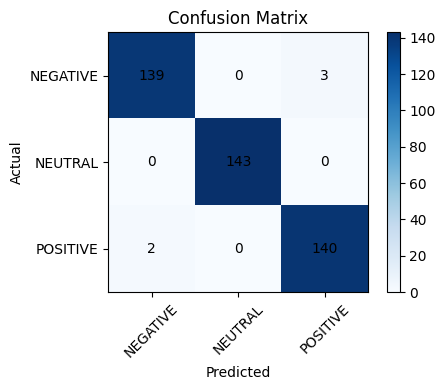

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()